# Risk-targeted risk-parity portfolio: 

This document computes a similar diversified risk-targeted risk parity portfolio as the  [Man AHL TargetRisk](https://www.man.com/ahl-targetrisk) or [Ray Dalio's All weather portfolio](https://www.optimizedportfolio.com/all-weather-portfolio/). There are some key differences between each portfolio implementation, however, they both try to diversify, equalize the marginal risk contribution and rescale the portfolio to allow for a specific annualized risk level.  

Additional links:

https://portfolioslab.com/portfolio/ray-dalio-all-weather


https://info.recipeinvesting.com/t.pure.html



In [62]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
def Riskparity(Sigma, b, risktarget):
    """
    Sigma: covariance matrix, 
    b: Risk contributions. For riskparity this should 1/n for n being amount of assets in universe. 
    risktarget: Insert risktarget and rescales portfolio. For annualized value then do risktarget * sqrt(252) using the square-root rule. 
    """ 
    import cvxpy as cp

    w = cp.Variable(4)  #portfolio weight
    obj = 0.5 * cp.quad_form(w, Sigma) - cp.sum(cp.multiply(b, cp.log(w)))  
    #objective
    constr = [w >= 0] 
    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve()
    # normalize weights as provided in Palomar documentation: 
    w = w/cp.sum(w)

    portrisk = cp.sqrt(cp.quad_form(w, Sigma))
    alpha = risktarget / portrisk
    w_new = w * alpha
    b_new = cp.multiply(w_new, Sigma @ w_new) / cp.quad_form(w_new, Sigma)  #solution risk budget af rescaling

    out = {"w_new": w_new.value, "w": w.value, "b_new": b_new.value}

    return(out)

def EWMA(returns, lmb= 0.94):
    """ Computes the simple multivariate Exponentially Weighted Moving Average estimator.

    Args:
        returns (np.array or dataframe): array or dataframe of returns
        lambda (float): Dampening/halflife factor. 
    """

    covar = np.zeros((returns.shape[1], returns.shape[1], returns.shape[0]))


    #initiate covar using unconditional covariance: 

    covar[:,:,0] = returns.cov()

    for i in range(len(returns)-1):
        covar[:,:,i+1] = lmb * covar[:,:,i] + (1-lmb) * np.outer(returns.iloc[i,:],returns.iloc[i,:]) #returns.T @ returns

    return(covar)






In [14]:

Sigma = np.array([[6.1, 2.9, -0.8, 0.1], 
                  [2.9, 4.3, -0.3, 0.9], 
                  [-0.8, -0.3, 1.2, -0.7],
                  [0.1, 0.9, -0.7, 2.3]])
b = np.ones(4)/4  #risk parity

risktarget = 0.1


In [39]:
#under square-root rule, we want the annualized volatility to be 10%, 0.1 * sqrt(252)
Riskparity(Sigma, b, 0.1 * np.sqrt(252)) #Correct. 

{'w_new': array([0.32619271, 0.26863174, 1.12768609, 0.64716242]),
 'w': array([0.13765305, 0.11336237, 0.47588258, 0.273102  ]),
 'b_new': array([0.25000017, 0.24999975, 0.24999992, 0.25000017])}

In [64]:
tickers = ["SPY", "GLD", "TLT", "HYG", "TIP"] #Stocks, Gold, Longterm Treasuries, Corporate bonds (High Yield), Treasure inflation protected bonds (a bet on rising inflation).
data = []

for i in tickers: 
    stockdata = yf.download(i, start = "1997-01-01", end = "2022-04-01")[['Adj Close', 'Volume']]
    data.append(stockdata['Adj Close'])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
DF = pd.DataFrame(data).T
DF.columns = tickers
DF = DF.dropna(axis = 0)

In [66]:
DF_Returns = DF.pct_change().dropna() #Working with linear returns for portfolio modelling. 
DF_Returns.head()
DF_LOGReturns = pd.DataFrame(np.diff(np.log(DF))) #Percentage log-returns

In [119]:
tt = EWMA(DF_LOGReturns)


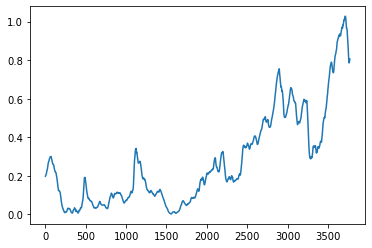

In [125]:
plt.plot(tt[0,0,:])


